In [1]:
from utils.all import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6, 7, 8, 9], preprocess=True) # batch_num=1,

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json', '../annotated/batch_7_anton.json', '../annotated/batch_7_ayush.json', '../annotated/batch_7_kelly.json', '../annotated/batch_7_rachel.json', '../annotated/batch_7_vinayak.json', '../annotated/batch_7_vishnesh.json', '../annotated/batch_8_anton.json', '../annotated/batch_8_ayush.json', '../annotated/batch_8_kelly.json', '../annotated/batch_8_rachel.json', '../annotated/batch_8_vinayak.json', '../annotated/batch_8_vishnesh.json', '../annotated/batch_9_ayush.json', '../annotated/batch_9_kelly.json', '../annotated/batch_9_rachel.json', '../annotated/

In [2]:
# Show the agreement with SimpEval
# simpeval_agreement(data)

In [3]:
sent = [sent for sent in data if sent['batch'] == 5 and sent['hit_id'] == 11 and sent['user'] == 'vishnesh'][0]
get_sent_info(sent)

'vishnesh - Batch 5, HIT 12 (ID 6)'

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def token_level_disagreement(data, collapse_composite=False, majority_disagreement=False):
    total_agreement = []
    MAX_HIT = max([x['id'] for x in data])+1
    for sent_id in range(0, MAX_HIT):
        sents = [x for x in data if x['id'] == sent_id]
        orig_tokens = get_annotations_per_token(sents, 'original', collapse_composite=collapse_composite)
        simp_tokens = get_annotations_per_token(sents, 'simplified', collapse_composite=collapse_composite)

        arr_edits = []
        for edits in list(orig_tokens.values()) + list(simp_tokens.values()):
            out = []
            for k, v in edits.items():
                for amt in range(v):
                    out += [k]
            for i in range(3 - len(out)):
                out += [None]
            arr_edits += [out]

        if majority_disagreement:
            # This takes edits with a 2 agreeing annotators and 1 disagreeing annotator
            # and reports agreement between the majority and minority classes
            disagreement = []
            for edit in arr_edits:
                majority, minority = None, None
                if edit[0] == edit[1]:
                    majority = edit[0]
                    minority = edit[2]
                elif edit[1] == edit[2]:
                    majority = edit[1]
                    minority = edit[0]
                elif edit[0] == edit[2]:
                    majority = edit[0]
                    minority = edit[1]
                
                if majority is None or minority is None or majority == minority:
                    continue
            
                disagreement += [[majority, minority]]
        else:
            # This replicates each edit and calculates pairwise agreement
            # [A1, A2]
            # [A2, A3]
            # [A3, A1]
            interwoven = []
            for edit in arr_edits:
                interwoven += [[edit[0], edit[1]]]
                interwoven += [[edit[1], edit[2]]]
                interwoven += [[edit[0], edit[2]]]
            
            disagreement = []
            for edit in interwoven:
                # Important point, could be 'or'
                if edit[0] is None or edit[1] is None:
                    continue
                # Cannot display agreement
                if edit[0] == edit[1]:
                    continue
                disagreement += [edit]

        total_agreement += disagreement
    return total_agreement

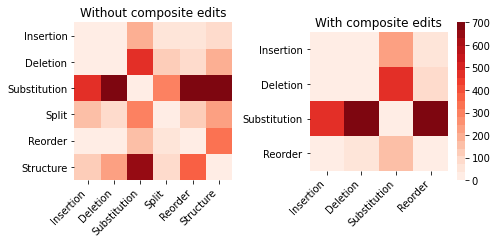

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5)) #sharex=True, sharey=True)

vmin, vmax = 0, 700

color_bar = sn.color_palette("Reds", 20)

disagreement = token_level_disagreement(data)
a = confusion_matrix([x[0] for x in disagreement], [x[1] for x in disagreement], labels=edit_type_labels)
df_cm = pd.DataFrame(a, index=[x.capitalize() for x in edit_type_labels], columns=[x.capitalize() for x in edit_type_labels])
sn.heatmap(df_cm, cmap=color_bar, ax=ax1, vmin=vmin, vmax=vmax, square=True, cbar=False)

# For numbers add:
# , annot=True, fmt=".1f")

disagreement = token_level_disagreement(data, collapse_composite=True)
a = confusion_matrix([x[0] for x in disagreement], [x[1] for x in disagreement], labels=[x for x in edit_type_labels if x not in ['structure', 'split']])
df_cm = pd.DataFrame(a, index=[x.capitalize() for x in edit_type_labels if x not in ['structure', 'split']], columns=[x.capitalize() for x in edit_type_labels if x not in ['structure', 'split']])
sn.heatmap(df_cm, cmap=color_bar, ax=ax2, vmin=vmin, vmax=vmax, square=True)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

ax1.set_title('Without composite edits')
ax2.set_title('With composite edits')

fig.tight_layout()

out_filename = "img/agreement-heatmap.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)

plt.show()

In [6]:
# Confusion matrix of different types of errors.
# Entry at row i, column j corresponds to the frequency
# of annotations that have Fi as the majority class and for
# which disagreeing annotator selected Fj.


# Instead calculate agreement using split & strucure's composite edits
# Change color scheme
# Remove numbers

# FRANK paper had the "majority class" as 1 axis and the "minority class" as 
# another axis. Redo code to show that instead. Write this in paper

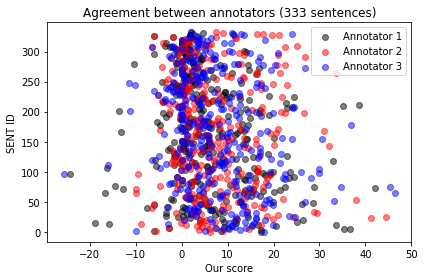

In [7]:
# Calculate the inter-annotator agreement on sentence-level scores
final = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [x['score'] for x in sents]
    
    # Delete this: if not all scores are present, skip this sentence
    if len(scores) != 3:
        continue
    
    final.append(scores)

# Plot the scores for each sentence
ann_mapping = {
    0: 'black',
    1: 'red',
    2: 'blue'
}
for ann in range(0, 3):
    pts = [(i, score) for i, score in enumerate([x[ann] for x in final])]
    plt.scatter([p[1] for p in pts], [p[0] for p in pts], c=ann_mapping[ann], alpha=0.5, label=f'Annotator {ann+1}')
plt.xlabel('Our score')
plt.ylabel('SENT ID')
plt.title(f'Agreement between annotators ({len(pts)} sentences)')
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

In [8]:
# Calculates Rough Span Agreement Score
# TODO: Does not work for multiple batches
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_annotations_per_token(sents, 'original')
    simp_tokens = get_annotations_per_token(sents, 'simplified')
    agg_score = 0
    for val in list(orig_tokens.values()) + list(simp_tokens.values()):
        agg_score += (list(val.values())[0] - 3)
    total_agreement.append(agg_score)
print(f"Sent with full agreement {sum([x == 0 for x in total_agreement])} / {MAX_HIT}")
# hds = sorted([(i, val) for i, val in enumerate(total_agreement)], key=lambda x: x[1])
# print("\nHighest disagreement sentences:")
# for x in [get_sent_info(data[x[0]]) for x in hds][:5]:
#     print(x)

Sent with full agreement 40 / 419


In [9]:
# The problem right now is most disagreement is between structure and other changes
# However structure is a composite of other changes. So is it really *span* selection?
# We count structure twice. Once as a span itself, and once as each of its composite spans
# Hopefully agreement goes up? Might not...

In [10]:
# First need to add a new field to structure edits containing its composite edits. Basically just needs the spans and type
# Then, in the function, we modify the edits array to also include the composite edits.

{(5, 11): {'substitution': 3},
 (32, 39): {'substitution': 2, 'structure': 1},
 (40, 45): {'structure': 1},
 (46, 48): {'substitution': 2, 'structure': 2},
 (49, 55): {'substitution': 2, 'structure': 2},
 (85, 88): {'split': 3, 'deletion': 1},
 (97, 104): {'substitution': 3},
 (120, 123): {'substitution': 2},
 (124, 131): {'substitution': 2},
 (132, 140): {'substitution': 2}}

{(5, 9): {'substitution': 3},
 (30, 35): {'substitution': 2, 'structure': 1},
 (36, 41): {'structure': 1},
 (42, 50): {'substitution': 2, 'structure': 2},
 (80, 82): {'split': 3},
 (83, 85): {'split': 3, 'insertion': 1},
 (86, 90): {'split': 2, 'insertion': 1},
 (91, 93): {'split': 2, 'insertion': 1},
 (94, 99): {'split': 2, 'insertion': 1},
 (109, 113): {'substitution': 3},
 (129, 137): {'substitution': 2}}

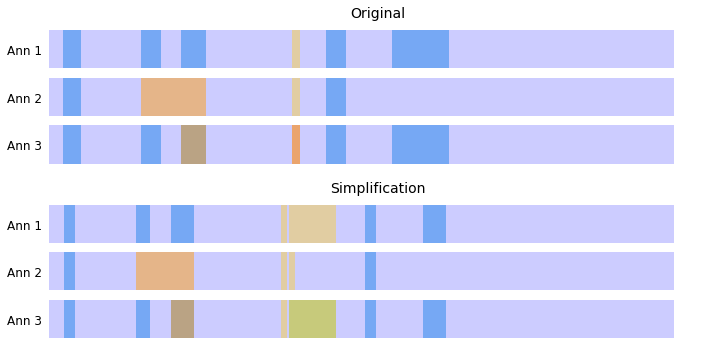

In [11]:
HID_ID = 12
sents = [x for x in data if x['id'] == HID_ID]
orig_tokens = get_annotations_per_token(sents, 'original')
simp_tokens = get_annotations_per_token(sents, 'simplified')

display(orig_tokens)
display(simp_tokens)
draw_agreement(sents, paper=True)

In [12]:
# Calculates % Agreement
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_annotations_per_token(sents, 'original')
    simp_tokens = get_annotations_per_token(sents, 'simplified')
    total_agreement += list(orig_tokens.values()) + list(simp_tokens.values())

span_agreement = {}
for edit_type in edit_type_labels:
    out = {
        3: 0,
        2: 0,
        1: 0
    }
    for d in total_agreement:
        if edit_type in d.keys():
            if d[edit_type] not in out.keys():
                out[d[edit_type]] = 0
            out[d[edit_type]] += 1
    total = sum(out.values())
    # Avoid division by 0, doesn't change calculation at all
    total = 1 if total == 0 else total
    print(f'{edit_type}: {int(100*out[3]/total)} {int(100*out[2]/total)} {int(100*out[1]/total)}')
    span_agreement[edit_type] = {
        'three': int(100*out[3]/total),
        'two': int(100*out[2]/total)
    }

insertion: 14 28 57
deletion: 42 22 34
substitution: 25 32 41
split: 30 24 44
reorder: 12 28 58
structure: 4 20 74


In [13]:
from sklearn.metrics import cohen_kappa_score
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from statsmodels.stats import inter_rater as irr

for edit in edit_type_labels:
    total_agreement = None
    MAX_HIT = max([x['id'] for x in data])+1
    for sent_id in range(0, MAX_HIT):
        sents = [x for x in data if x['id'] == sent_id]
        final = []
        for sent in sents:
            tokens_orig = get_annotations_per_token([sent], 'original', remove_none=False)
            tokens_simp = get_annotations_per_token([sent], 'simplified', remove_none=False)
            all_edits = list(tokens_orig.values()) + list(tokens_simp.values())
            formatted = []
            for edits in all_edits:
                if edit in edits.keys():
                    formatted += [1]
                else:
                    formatted += [0]
                # formatted += [nx]
            final += [formatted]
        
        if len(sents) == 3:
            if total_agreement is None:
                total_agreement = np.asarray(final)
            else:
                total_agreement = np.append(total_agreement, np.asarray(final), axis=1)
    
    # Delete columns with all 0s
    # idx = np.argwhere(np.all(total_agreement[..., :] == 0, axis=0))
    # total_agreement = np.delete(total_agreement, idx, axis=1)

    
    value_counts = total_agreement
    print(f"{edit} ({total_agreement.shape[1]} tokens)")
    # Having trouble formatting the krippendorff alpha
    # print(krippendorff.alpha(value_counts=value_counts, level_of_measurement='nominal'))
    print(cohen_kappa_score(total_agreement[0, :], total_agreement[1, :]))
    print(cohen_kappa_score(total_agreement[1, :], total_agreement[2, :]))
    print(cohen_kappa_score(total_agreement[0, :], total_agreement[2, :]))
    agg = irr.aggregate_raters(total_agreement.T)
    agg_fleiss = irr.fleiss_kappa(agg[0], method='fleiss')
    print(agg_fleiss, end='\n\n')

    span_agreement[edit]['fleiss'] = agg_fleiss

insertion (23607 tokens)
0.456774162193746
0.52164429344534
0.4560359841306473
0.4811816545989259

deletion (23607 tokens)
0.7667699171336345
0.7543324116097235
0.7711454594750473
0.7638904402163159

substitution (23607 tokens)
0.5838143341523736
0.6098519271123053
0.589750441188193
0.5941907466765071

split (23607 tokens)
0.5849846430937851
0.6761554915775658
0.7034114504954678
0.6537211619690851

reorder (23607 tokens)
0.45087272814578283
0.44336290290209934
0.431394980401698
0.4418292737591245

structure (23607 tokens)
0.20552444838770356
0.29978793878923116
0.2289259458243771
0.2463029891890205



In [24]:
table_edit_type_mapping = {
    'insertion': '\\ei{Insertion}', 
    'deletion': '\\ed{Deletion}', 
    'substitution': '\\es{Substitution}', 
    'reorder': '\\er{Reorder}', 
    'split': '\\esp{Split}', 
    'structure': '\\est{Structure}'
}
table = ''
for edit_type in table_edit_type_mapping.keys():
    table += f'{table_edit_type_mapping[edit_type]} & {round(span_agreement[edit_type]["fleiss"], 2)} & {span_agreement[edit_type]["three"]} & {span_agreement[edit_type]["two"]} \\\\\n'

print(table)

\ei{Insertion} & 0.48 & 14 & 28 \\
\ed{Deletion} & 0.76 & 42 & 22 \\
\es{Substitution} & 0.59 & 25 & 32 \\
\er{Reorder} & 0.44 & 12 & 28 \\
\esp{Split} & 0.65 & 30 & 24 \\
\est{Structure} & 0.25 & 4 & 20 \\



In [55]:
# Calculates agreement for errors
error = Error.BAD_DELETION

def get_error_stats(error):
    total_agreement = None
    MAX_HIT = max([x['id'] for x in data])+1
    for sent_id in range(0, MAX_HIT):
        sents = [x for x in data if x['id'] == sent_id]

        sents_errors = []
        for sent in sents:
            errors = []
            for ann in sent['processed_annotations']:
                if (error.value == 'grammar_error' and ann['grammar_error']) or ann['error_type'] == error:
                    errors += [1]
                else:
                    errors += [0]
            sents_errors += [1 if any(errors) == True else 0]

        # Converts error array to 0/1 mapping using alphabetical ordering
        if len(sents_errors) == 3:
            if total_agreement is None:
                total_agreement = np.asarray([sents_errors])
            else:
                total_agreement = np.append(total_agreement, np.asarray([sents_errors]), axis=0)

    if total_agreement.sum() == 0:
        print(f'No {error.value} errors', end='\n\n')
        return None

    stats = {}
    agg = irr.aggregate_raters(total_agreement)
    stats['fleiss'] = irr.fleiss_kappa(agg[0], method='fleiss')

    # Delete columns with all 0s
    total_agreement = total_agreement.T
    idx = np.argwhere(np.all(total_agreement[..., :] == 0, axis=0))
    total_agreement = np.delete(total_agreement, idx, axis=1)
    total_agreement = total_agreement.T

    # % two agree
    two_agree = []
    for entry in total_agreement:
        two_agree.append(np.sum(entry) >= 2)
    stats['two'] = 100*sum(two_agree) / total_agreement.shape[0]

    # % frequency
    stats['freq'] = 100*len(total_agreement) / MAX_HIT

    return stats

class Tmp(Enum):
    GRAMMAR_ERROR = 'grammar_error'

table = ''
all_stats = {}
for error in [e for e in Error] + [Tmp.GRAMMAR_ERROR]:
    stats = get_error_stats(error)
    if stats is not None:
        all_stats[error] = stats

sorted_stats = sorted([(k, v['freq']) for k, v in all_stats.items()], key=lambda x: x[1], reverse=True)

for error in [x[0] for x in sorted_stats]:
    table += f'{error.value} & {round(all_stats[error]["fleiss"], 2)} & {int(all_stats[error]["two"])} & {int(all_stats[error]["freq"])} \\\\ \n'
table = table.replace('grammar_error', 'Grammar Error')

print(table)

No Hallucination errors

No Unnecessary Insertion errors

Bad Deletion & 0.51 & 68 & 42 \\ 
Complex Wording & 0.24 & 31 & 18 \\ 
Information Rewrite & 0.22 & 25 & 13 \\ 
Grammar Error & 0.15 & 21 & 12 \\ 
Bad Structure & 0.0 & 4 & 10 \\ 
Irrelevant & 0.19 & 23 & 9 \\ 
Bad Reorder & 0.14 & 16 & 8 \\ 
Repetition & 0.33 & 26 & 4 \\ 
Bad Split & 0.24 & 35 & 4 \\ 
Contradiction & 0.12 & 14 & 1 \\ 
Coreference & -0.0 & 0 & 0 \\ 



In [16]:
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import krippendorff

# Calculates sentence-score agreement
total_agreement = None
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [sent['score'] for sent in sents]
    if len(scores) == 3:
        if total_agreement is None:
            total_agreement = np.asarray([scores])
        else:
            total_agreement = np.append(total_agreement, np.asarray([scores]), axis=0)

tau, p_value = kendalltau(total_agreement[:, 1], total_agreement[:, 2])
r, p_value = pearsonr(total_agreement[:, 1], total_agreement[:, 2])
kd = krippendorff.alpha(value_counts=total_agreement, level_of_measurement='nominal')
print(tau)
print(r)
print(kd)

0.3356323120269085
0.4007365568567711
0.3785056005908405


In [17]:
# Some examples of high disagreement
# This isn't the correct way to calculate disagreement between the scores
# high_disagreement = [y[1] for y in sorted([(abs(x[0] - x[1]), i) for i, x in enumerate(scores) if x[0] != 0], reverse=True)][:5]
# for idx in high_disagreement:
#     example = data[idx]
#     print(f'HIT {example["id"] + 1}\nAnnotator: {example["user"]}\nSimpEval Score: {example["simpeval_scores"]}\nOur Score: {example["score"]}\nSystem: {system_name_mapping[example["system"]]}\n')

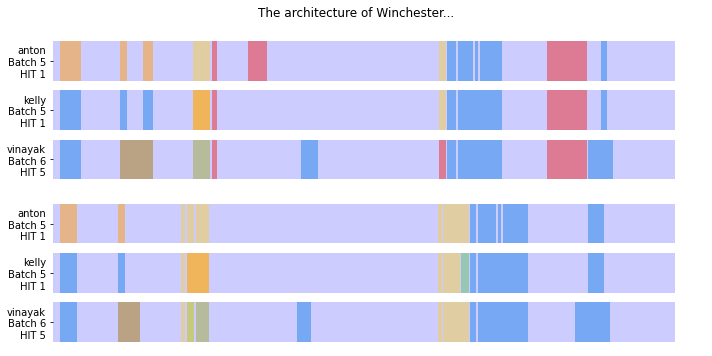

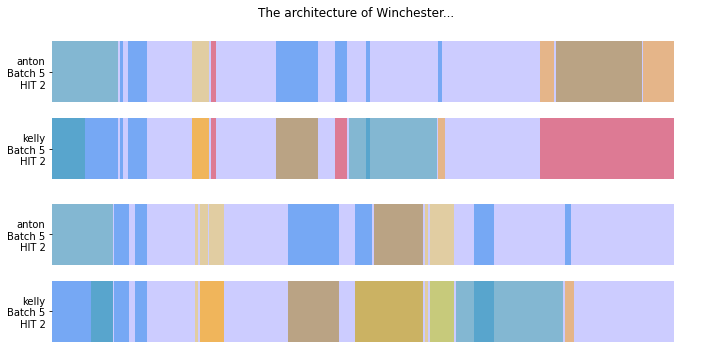

In [18]:
# Display the agreeement on all sentences
MAX_HIT = 2 # max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    draw_agreement(sents)

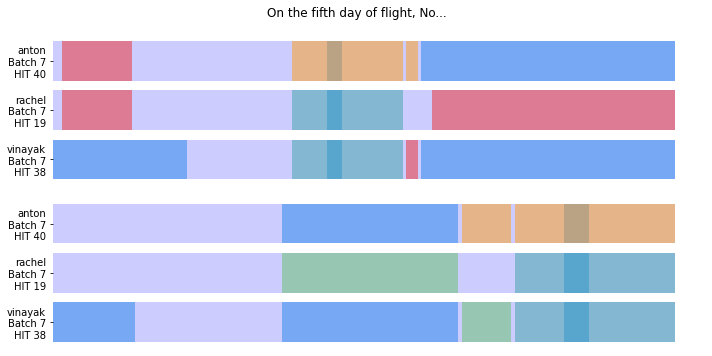

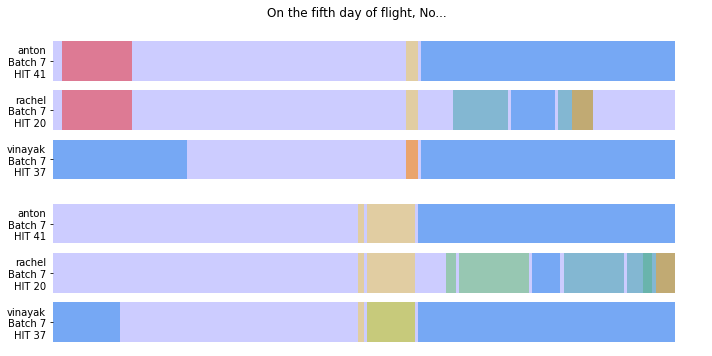

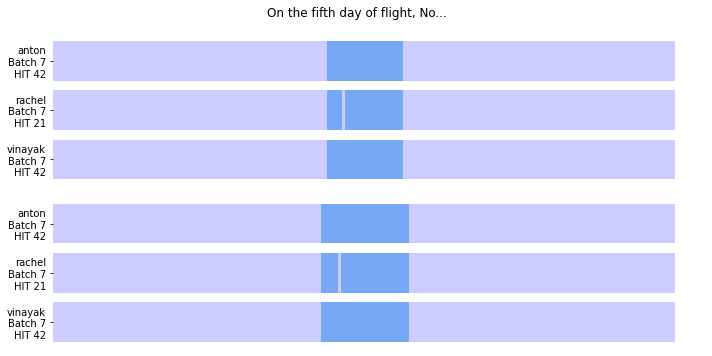

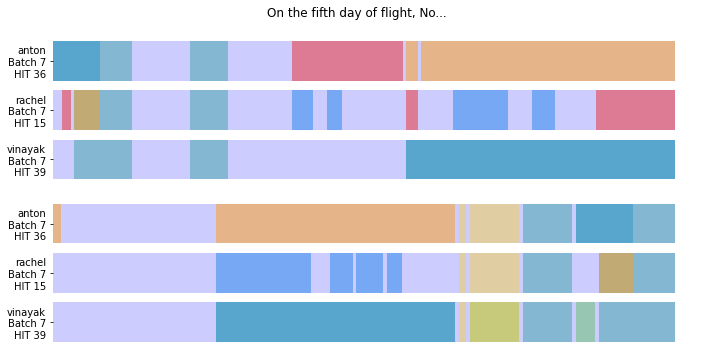

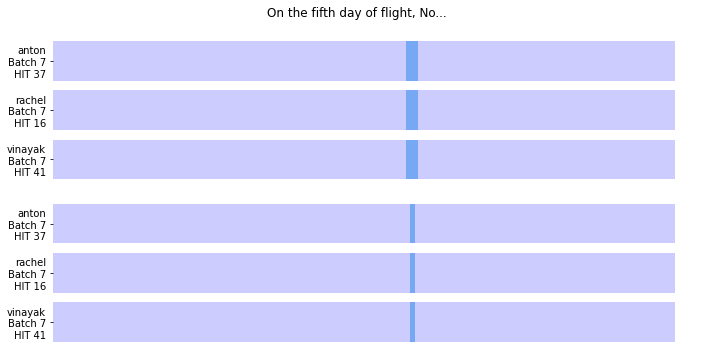

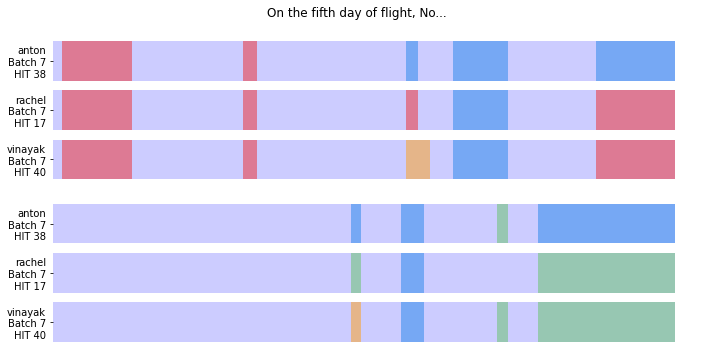

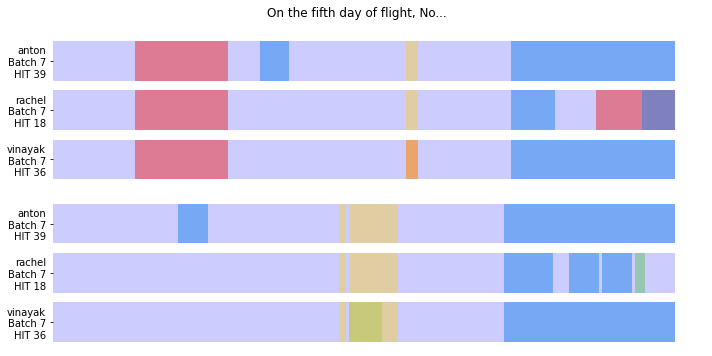

In [19]:
selected = [sent for sent in data 
    if 'Orion' in sent['original']
]
for sent_id in set([x['id'] for x in selected]):
    sents = [x for x in selected if x['id'] == sent_id]
    draw_agreement(sents)

In [20]:
for sent in set([x['simplified'] for x in selected]):
    print(sent, end='\n\n')

On the fifth day of flight, November 20, 2022, at 19:09 UTC, the Orion spacecraft entered the Lunar sphere of influence, so the Moon's gravitational force became stronger than Earth's relative to the spacecraft.

On November 20, 2022 at 19:09 UTC, the Orion spacecraft began to be affected by the Moon's gravity, since it had entered the Moon's sphere of influence.

On the fifth day of flight, the Orion spaceship entered the Lunar sphere of influence. || This means that the Moon's gravitational force could influence the spaceship more than the Earth's.

On November 20, 2022, at 19:09 UTC, the spacecraft entered the lunar sphere of influence and the Moon's gravity became stronger than the Earth's when the spacecraft was very close to it.

On the fifth day of flight, November 20, 2022, at 19:09 UTC, the Orion spacecraft entered the Moon's gravitational dominance, thus the Moon's gravitational force became stronger than Earth's relative to the spacecraft.

On November 20, 2022, the Orion sp